# Particle Flow Test 1

Make our own particle flow network, train it on photon jets

In [1]:
# Up to a couple minutes to import everything

# Computing imports
print(f"Importing computing things...")
import os
import numpy as np

print(f"Importing tensorflow... (this could take a while)")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # Make tensorflow quieter
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Useful imports
print(f"Importing display things...")
from tqdm import tqdm
import matplotlib.pyplot as plt

# Energyflow imports
print(f"Importing energyflow things...")
from energyflow.utils import data_split, to_categorical

# Own imports
from utils import convert_size

Importing computing things...
Importing tensorflow... (this could take a while)
Importing display things...
Importing energyflow things...


In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print(f"Available GPUs: {gpus}")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import, preprocess data

Data lives in `X_train`, `X_val`, `X_test`, and `Y_train`, `Y_val`, `Y_test`.

In [3]:
# ~10 sec
jets_path = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/processed/scalar_test/all_jets_point_cloud.npz"
jets = np.load(jets_path)

X, y = jets["X"], jets["y"]
Y = to_categorical(y)

print("Loaded data")

Loaded data


In [4]:
print(X.shape)
print(Y.shape)

(300000, 960, 4)
(300000, 3)


In [5]:
# ~5 sec
# Do train/val/test split
N = len(X)
n_val = int(0.1 * N)
n_test = int(0.1 * N)

(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=n_val, test=n_test)

print("Done train/val/test split")

Done train/val/test split


## Define the model

PFN model:
$$\text{PFN}=F\left(\sum_{i=1}^M \Phi(p_i)\right)$$

In [6]:
def PFN(n_features,
        n_particles,
        n_outputs,
        Phi_sizes,
        F_sizes,
        name=None):
    
        inputs = layers.Input((n_particles, n_features), name="input")    
        masking_layer = layers.Masking(
            mask_value=0.,
            input_shape=(n_particles, n_features)
        )
        Phi_layers = [
            layers.Dense(size, activation="relu", name=f"Phi_{i}") \
            for i, size in enumerate(Phi_sizes)
        ]
        F_layers = [
            layers.Dense(size, activation="relu", name=f"F_{i}") \
            for i, size in enumerate(F_sizes)
        ]
        last_layer = layers.Dense(n_outputs, name="output")
        
        x = masking_layer(inputs)
        for layer in Phi_layers:
            x = layers.TimeDistributed(layer)(x)
        x = tf.math.reduce_sum(x, axis=1)
        for layer in F_layers:
            x = layer(x)
        x = last_layer(x)
        
        return tf.keras.Model(inputs=inputs, outputs=x)

## Compile and train the model

In [7]:
model_dir = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/models/pfn"

In [8]:
try:
    del fit_history
    del model
except NameError:
    pass

tf.keras.backend.clear_session()

In [9]:
memory_usage = tf.config.experimental.get_memory_info("GPU:0")
print("GPU memory usage")
print(f"  current: {convert_size(memory_usage['current'])}")
print(f"  peak:    {convert_size(memory_usage['peak'])}")

GPU memory usage
  current: 0B
  peak:    0B


In [ ]:
# Takes about 5 sec the first time
# Data dimensions
n_features = 4
n_particles = 960

model = PFN(
    n_features=n_features,
    n_particles=n_particles,
    n_outputs=3,
    Phi_sizes=(128,) * 4 + (64,) * 3,
    F_sizes=(128,) * 4 + (64,) * 3
)

In [10]:
# Alternatively, load the model from memory
# ~5 sec
model = tf.keras.models.load_model(f"{model_dir}/97.27pc.model")

In [20]:
lr = 2e-8

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [21]:
fit_history = model.fit(X_train, Y_train,
                        epochs=10,
                        batch_size=100,
                        validation_data=(X_val, Y_val),
                        verbose=1)

Epoch 1/10
2400/2400 [==============================] - 55s 20ms/step - loss: 0.0704 - accuracy: 0.9762 - val_loss: 0.0712 - val_accuracy: 0.9765
Epoch 2/10
2400/2400 [==============================] - 47s 20ms/step - loss: 0.0703 - accuracy: 0.9763 - val_loss: 0.0712 - val_accuracy: 0.9763
Epoch 3/10
2400/2400 [==============================] - 47s 20ms/step - loss: 0.0703 - accuracy: 0.9762 - val_loss: 0.0712 - val_accuracy: 0.9760
Epoch 4/10
2400/2400 [==============================] - 47s 20ms/step - loss: 0.0703 - accuracy: 0.9762 - val_loss: 0.0712 - val_accuracy: 0.9762
Epoch 5/10
2400/2400 [==============================] - 47s 20ms/step - loss: 0.0703 - accuracy: 0.9763 - val_loss: 0.0712 - val_accuracy: 0.9761
Epoch 6/10
2400/2400 [==============================] - 47s 19ms/step - loss: 0.0703 - accuracy: 0.9763 - val_loss: 0.0712 - val_accuracy: 0.9765
Epoch 7/10
2400/2400 [==============================] - 47s 19ms/step - loss: 0.0703 - accuracy: 0.9763 - val_loss: 0.0712 -

In [ ]:
# ~5 sec
model.save("/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/models/pfn/pfn_97.51pc.model")

INFO:tensorflow:Assets written to: /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/models/pfn/pfn_97.51pc.model/assets


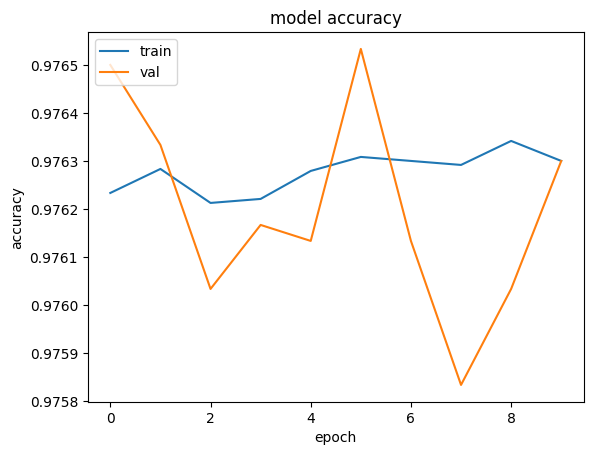

In [22]:
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

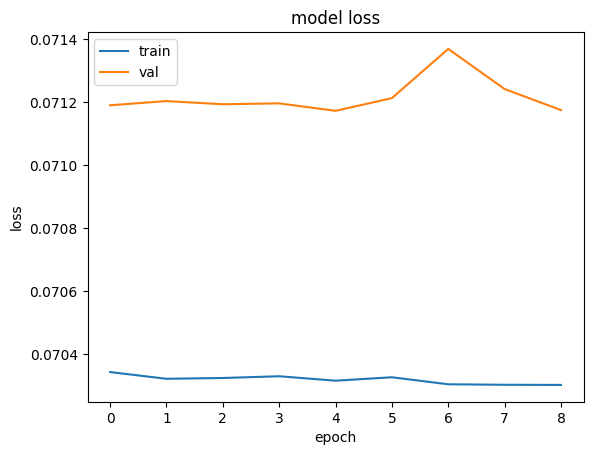

In [23]:
plt.plot(fit_history.history['loss'][1:])
plt.plot(fit_history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# get predictions on test data
preds = model.predict(X_test, batch_size=500)

60/60 [==============================] - 2s 29ms/step


In [25]:
test_labels = np.argmax(Y_test, axis=1)
pred_labels = np.argmax(preds, axis=1)

mask = (test_labels == pred_labels).astype(float)
print(mask)
print(f"Test accuracy: {mask.mean()}")

[1. 1. 1. ... 1. 1. 1.]
Test accuracy: 0.9753


Total test jets: 30000


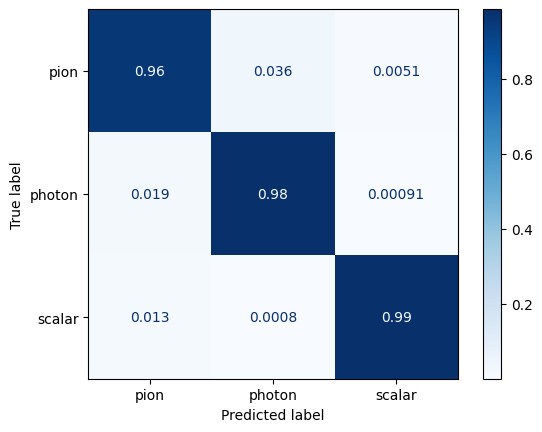

In [26]:
cm = confusion_matrix(test_labels, pred_labels).astype(float)
cm /= np.sum(cm, axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["pion", "photon", "scalar"]
);
disp.plot(cmap="Blues");

print(f"Total test jets: {len(test_labels)}")